### 1.0 | Assignment 2: Evaluating Classification Models

### Overview:

For this problem a bank has asked that a machine learning model be generated to predict whether or not a customer will subscribe to a term deposit in response to a marketing campaign. To train the machine learning model a set of data has been provided including key predictor variables and the outcome from a previous marketing effort. The goal is to use this training data to design a logistic regression model and a naive bayes model and to determine which model is best suited for making the prediction. In this case, the scoring measure for sucess will be the ROC-AUC score which measures the trade-off between true positive and false positive predictions. 
<br>

The first step in model development is to examine the training data and make any necassary adjustments to prep it for further analysis. In this case, three of the predictor variables and response variable are binary and were converted from text response ('yes'/'no') to binary numerical values (1/0). Additionally, all continuous fields were scaled and categorical fields were encoded. The predictor variables, default, housing and loan, were analyzed for their individual predictor value. All three variables scored a ROC-AUC score between .46 and .5 meaning that they were no better than random guesses. Finally, the binary predictor variables were evaluated for correlation to one another. In other words, did any two variables exhibit patterns in their values? It was determined that none of the vaues had any significant correlation. Likewise, the categorical variables were analyzed to determine if any of the values exhibited a relationshp with the response variable. In other words, did customers who were married disproportionally have a positive response variable?
<br>

Once the data was thorougly vetted, the values were split into a training and test set. The training data was first evaluated in a logistic regression model using GridSearchCV, a cross validation tool that tweaks hyperparameters to optimize the desired outcome, which in this case was the highest ROC-AUC score possible. This optimized model achieved a ROC-AUC mean score of .83 on the validation folds and only a score of .55 on the test data, which was hardly better than guessing. The second model, the Naive Bayes model, was evaluated using standard cross-validation scoring and achieved a score of .78. Against the test data, this score fell to .63. Both models showed strong performance on the validation sets but dropped off significantly against the test data indicating that additional regularization would be helpful. The Naive Bayes accurately predicted 48 positive response variable from a pool of 152 actual positive response variables in the test data. The Logistic Regressor predicted accurately on 17 responses of the 152 actual positive response variables. While neither model was very successful, the Naive Bayes showed the most promise as it successfully predicted more correct respones. Analzying the Naives Bayes results, the two strongest predictors were duration, the length of the call with the customer the previous attempt, and housing, whether or not the customer had a housing loan. 
<br>

The recommendations for management are to use the Naive Bayes model for future predictions. Most importantly, it is suggested that additional predictor variables and models be considered to improve the ROC-AUC score as the current model based on the available predictor variables is not very insightful. That being said, based on the model in its current state, it is suggested that the bank should market to individuals with a housing loan who were willing to spend more time on the phone the last time they were contacted by the bank.

### 1.1 | Load Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #scale any continuous fields
from sklearn.preprocessing import Imputer #impute any missing values
from sklearn.preprocessing import LabelBinarizer #binarize response field
from sklearn.preprocessing import OneHotEncoder #one-hot encode cat variables
#################################################
from sklearn.model_selection import GridSearchCV #cv technique for log classifier
from sklearn.model_selection import cross_val_score #cv technique for bayes classifer
from sklearn import metrics #to evaluate model performances
from sklearn.linear_model import LogisticRegression #Logistic Classifier
from sklearn.naive_bayes import GaussianNB #Bayes Classifier
import warnings

warnings.filterwarnings("ignore")

### 1.2 | Import Data

In [2]:
file = "C:/Users/David/OneDrive/MSDS/MSDS422/Week2/bank.csv"
df = pd.read_csv(file,sep = ';')
print('df rows:',len(df))
df.head()

df rows: 4521


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


### 1.3 | Data Pre-Processing

In [3]:
#isolate cat/cont/response fields
cat_fields = ['default','housing','loan']
cont_fields = ['balance','duration']
response_fields = ['response']

# binarize binary field
for i in ['default','housing','loan','response']:
    lb = LabelBinarizer()
    df[i] = lb.fit_transform(df[i])

#now all fields are defined in 0/1 values
df[['default','housing','loan','response']].head()

,default,housing,loan,response
0,0,0,0,0
1,0,1,1,0
2,0,1,0,0
3,0,1,1,0
4,0,1,0,0


In [4]:
# looking at structure of categorical predictor variables. Since some of the variabes have more than two values, one-hot
# encoding will need to be executed.
df[cat_fields].describe()

,default,housing,loan
count,4521.000000,4521.000000,4521.000000
mean,0.016810,0.566025,0.152842
std,0.128575,0.495676,0.359875
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [5]:
# check for any NA values to determine whether imputing is necassary
for i in cat_fields:
    print('NA count for',i,':',len(df[df[i].isna() == True]))

NA count for default : 0
NA count for housing : 0
NA count for loan : 0


In [6]:
# looking at structure of categorical predictor variables. Since some of the variabes have more than two values, one-hot
# encoding will need to be executed.
df[cont_fields].describe()

,balance,duration
count,4521.000000,4521.000000
mean,1422.657819,263.961292
std,3009.638142,259.856633
min,-3313.000000,4.000000
25%,69.000000,104.000000
50%,444.000000,185.000000
75%,1480.000000,329.000000
max,71188.000000,3025.000000


In [7]:
# check for any NA values to determine whether imputing is necassary
for i in cont_fields:
    print('NA count for',i,':',len(df[df['loan'].isna() == True]))

NA count for balance : 0
NA count for duration : 0


### 1.4 | EDA

In [8]:
for i in cat_fields:
    print(pd.crosstab(index=df["response"],columns=df[i]))
    print("----------------------------------------------")
#based on each variable it looks like a 0 response for default and loan are somewhat correlated with a 1 response. Housing 
#doesn't appear to show much correlation. It appears that the interaction of variables will be what predicts response values

default      0   1
response          
0         3933  67
1          512   9
----------------------------------------------
housing      0     1
response            
0         1661  2339
1          301   220
----------------------------------------------
loan         0    1
response           
0         3352  648
1          478   43
----------------------------------------------


In [9]:
import sklearn.metrics as metrics 

for i in ['housing','default','loan']:
    print('-------------------------------------------------')
    print(i,"vs Response")
    print('-------------------------------------------------')
    print(metrics.confusion_matrix(df['response'],df[i], labels=None, sample_weight=None))
    print("Precision:",round(metrics.precision_score(df['response'],df[i], labels=None,sample_weight=None),2))
    print('Recall   :',round(metrics.recall_score(df['response'],df[i], labels=None,sample_weight=None),2))
    print('Accuracy :',round(metrics.accuracy_score(df['response'],df[i],sample_weight=None),2))
    print('F1_score :',round(metrics.f1_score(df['response'],df[i],sample_weight=None),2))
    print('ROC_AUC  :',round(metrics.roc_auc_score(df['response'],df[i],sample_weight=None),2))

#think of each variable like a prediction of response, you can see that loan and default are strong indicators. Using default
#alone would generate an accuracy of 87%. Likewise, using loan would generate an accuracy of 75% as the sole predictor. 
# Unfortunately in this case, I am interested in maximizing the roc_auc score by optimizing the trade off between TPR and FPR
# so the accuracy measure isn't very meaningful. Looking at the ROC_AUC, I can see that no single variable is more useful 
# than a random guess.

-------------------------------------------------
housing vs Response
-------------------------------------------------
[[1661 2339]
 [ 301  220]]
Precision: 0.09
Recall   : 0.42
Accuracy : 0.42
F1_score : 0.14
ROC_AUC  : 0.42
-------------------------------------------------
default vs Response
-------------------------------------------------
[[3933   67]
 [ 512    9]]
Precision: 0.12
Recall   : 0.02
Accuracy : 0.87
F1_score : 0.03
ROC_AUC  : 0.5
-------------------------------------------------
loan vs Response
-------------------------------------------------
[[3352  648]
 [ 478   43]]
Precision: 0.06
Recall   : 0.08
Accuracy : 0.75
F1_score : 0.07
ROC_AUC  : 0.46


<Figure size 432x288 with 0 Axes>

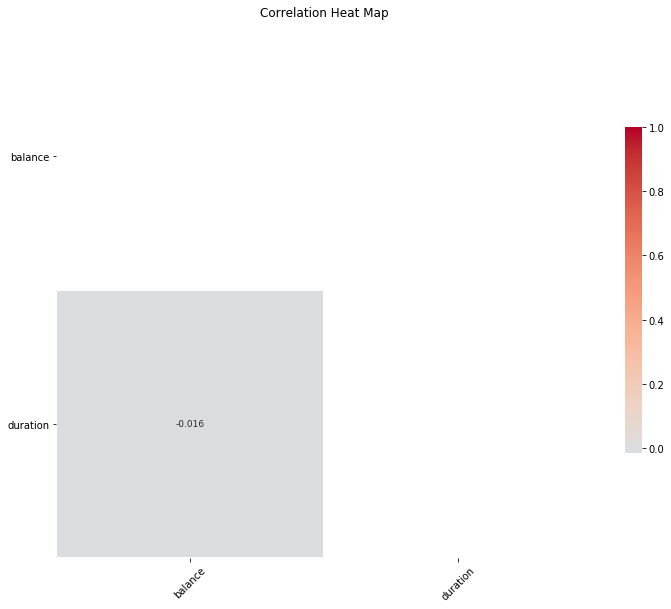

In [10]:
import seaborn as sns

def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None) 

for i in [cont_fields]:
    corr_chart(df_corr = df[i])

#this visual confirms that none of the variables are correlated with one another. In other words, when housing is equal to 1
# loan is not also equal to one

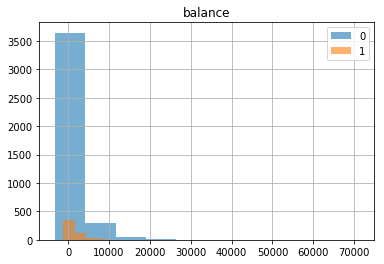

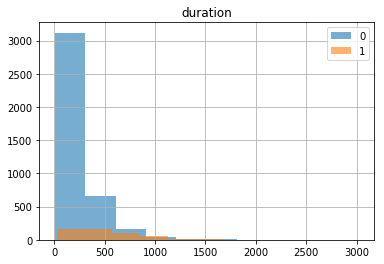

In [11]:
#Distribution of continuous fields separated by response
for i in cont_fields:
    plt.figure(i)
    df.groupby('response')[i].hist(alpha = .6)
    plt.title(i)
    plt.legend('01')

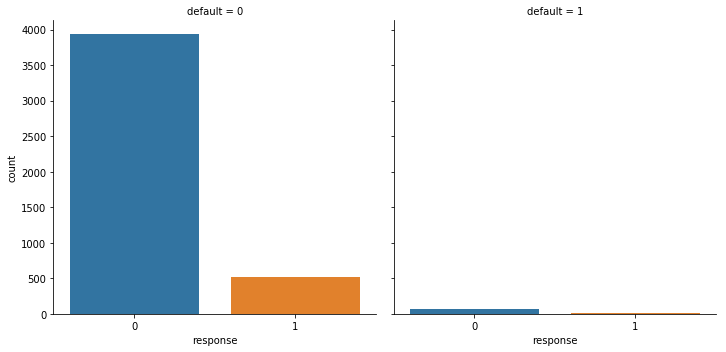

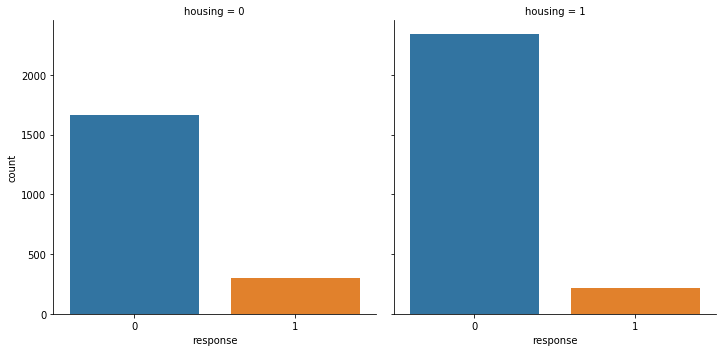

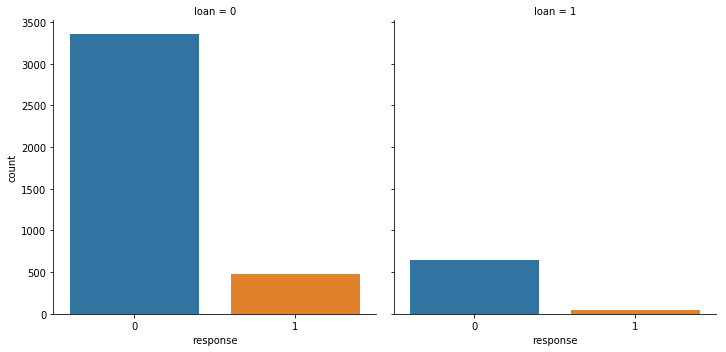

In [12]:
#generate bar chart of categorical fields distributed by response variable to identify any trends.
for i in cat_fields:
    sns.catplot(x='response',col = i, kind = 'count',data = df)

### 1.5 | Split into Training and Test Data

In [13]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = .3

#split data into train and test sets
train_x,test_x,train_y,test_y=train_test_split(df[cat_fields+cont_fields],df['response'],
                                               test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [14]:
#confirm split went according to plan
print("Row count of Xtrain:",len(train_x))
print("Row count of Ytrain:",len(train_y),"/ Numer of Positives: ",sum(train_y),"/ Positive ratio: ",round(sum(train_y)/len(train_y),2))
print("Row count of Xtest:",len(test_x))
print("Row count of Ytest:",len(test_y),"/ Numer of Positives: ",sum(test_y),"/ Positive ratio: ",round(sum(test_y)/len(test_y),2))

Row count of Xtrain: 3164
Row count of Ytrain: 3164 / Numer of Positives:  369 / Positive ratio:  0.12
Row count of Xtest: 1357
Row count of Ytest: 1357 / Numer of Positives:  152 / Positive ratio:  0.11


### 1.6 | Scale Test and Training Data 

In [15]:
#scale training data separate from test so as to not influence scaling
train_scaled = pd.DataFrame(StandardScaler().fit_transform(train_x[cont_fields]),
                   columns = train_x[cont_fields].columns, index = train_x.index)

train_x = pd.concat([train_x[cat_fields],train_scaled],axis = 1)

#scale test data likewise
test_scaled = pd.DataFrame(StandardScaler().fit_transform(test_x[cont_fields]),
                   columns = test_x[cont_fields].columns, index = test_x.index)

test_x = pd.concat([test_x[cat_fields],test_scaled],axis = 1)

print("Test Data shape:",test_x.shape)
print("Training Data shape: ",train_x.shape)

Test Data shape: (1357, 5)
Training Data shape:  (3164, 5)


C:\Users\David\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### 1.7 | One Hot Encoding of Categorical Variables

In [16]:
#this method is tricky since I want to one hot encode across a combined test and training set. If I were to encode test
#and training in isolation then I would run the risk of some values showing up only in one of the sets resulting in a mismatched
#number of columns

#define variable for identifying test and train
train_x['train'] = 1
test_x['train'] = 0

#Combine test and train data
combined = pd.concat([train_x,test_x],axis = 0)

#isolate categorical variables
cat_df = combined[cat_fields]

#one hot encode
cat_df_encoded = pd.get_dummies(cat_df,drop_first = True)

combined_2 = pd.concat([cat_df_encoded,combined[cont_fields],combined['train']],axis = 1)

#split combined data set back to train and test
train_x = combined_2[combined_2['train'] == 1]
test_x = combined_2[combined_2['train'] == 0]
#remove train field defined earlier
train_x.drop('train',axis = 1,inplace = True)
test_x.drop('train',axis = 1, inplace = True)

print("Test Data shape:",test_x.shape)
print("Training Data shape: ",train_x.shape)
#Check the columns are equal and and the rows counts remained the same

Test Data shape: (1357, 5)
Training Data shape:  (3164, 5)


### 1.6 | Model I: Logistic Regressor

In [17]:
# apply logistic regression grid search to model/data.
model1 = LogisticRegression()

# Perform grid search to zero in on optimal parameters.
param_grid = [{
     "fit_intercept":[True, False],
     "warm_start"   :[True, False],
     "penalty"      :['l2'], 
     "solver"       :['lbfgs','newton-cg'],
     "C"            :[1/10000, 1/1000, 1/100, 1/10, 1, 10, 100, 1000, 10000],
}]

# Evaluate performance of optimal model on test data.
grid_search = GridSearchCV(model1, param_grid, cv=5, scoring='roc_auc',return_train_score = True)
grid_search.fit(train_x, train_y)
bestmodel1  = grid_search.best_estimator_

#examine mean training roc_auc scores
print("Array of mean roc_auc scores achieved from cross-validation: ",grid_search.cv_results_['mean_train_score'].round(2))

Array of mean roc_auc scores achieved from cross-validation:  [0.82 0.82 0.82 0.82 0.81 0.81 0.81 0.81 0.82 0.82 0.82 0.82 0.8  0.8
 0.8  0.8  0.83 0.83 0.83 0.83 0.79 0.79 0.79 0.79 0.83 0.83 0.83 0.83
 0.78 0.78 0.78 0.78 0.83 0.83 0.83 0.83 0.78 0.78 0.78 0.78 0.83 0.83
 0.83 0.83 0.78 0.78 0.78 0.78 0.83 0.83 0.83 0.83 0.78 0.78 0.78 0.78
 0.83 0.83 0.83 0.83 0.78 0.78 0.78 0.78 0.83 0.83 0.83 0.83 0.78 0.78
 0.78 0.78]


In [18]:
#examine best training roc_auc score
print("Best roc_auc score acheived on cross-validation: ",round(grid_search.best_score_,2))

Best roc_auc score acheived on cross-validation:  0.83


In [19]:
# Apply bestmodel1 to out-of-sample test data `test_x`.
model1_pred = bestmodel1.predict(test_x)

# Asses performance of mod.
print("Accuracy : {}".format(metrics.accuracy_score(test_y, model1_pred).round(2)))
print("Precision: {}".format(metrics.precision_score(test_y, model1_pred, average="weighted").round(2)))
print("Recall   : {}".format(metrics.recall_score(test_y, model1_pred, average="weighted").round(2)))
print("f1-score : {}".format(metrics.f1_score(test_y, model1_pred, average="weighted").round(2)))
print("ROC-AUC  : {}".format(metrics.roc_auc_score(test_y, model1_pred).round(2)))
print("\n")
print("Confusion Matrix")
print(metrics.confusion_matrix(test_y, model1_pred))

Accuracy : 0.89
Precision: 0.86
Recall   : 0.89
f1-score : 0.86
ROC-AUC  : 0.55


Confusion Matrix
[[1189   16]
 [ 135   17]]


### 1.7 | Model: Naive Bayes Classifier

In [20]:
#define Naive Bayes model
model2 = GaussianNB()

# Perform grid search to zero in on optimal parameters.
model2.fit(train_x,train_y)

#generate cross validation score to measure success
scores = cross_val_score(model2,train_x,train_y,scoring = 'roc_auc',cv = 5)
#examine mean training roc_auc scores
print("Array of mean roc_auc scores achieved from cross-validation: ",scores.round(2))

Array of mean roc_auc scores achieved from cross-validation:  [0.72 0.81 0.81 0.8  0.75]


In [21]:
#generate cross validation score to measure success
print("Avg roc_auc score acheived on cross-validation: ",round(scores.mean(),2))

Avg roc_auc score acheived on cross-validation:  0.78


In [22]:
# Apply model2 to out-of-sample test data `test_x`.
model2_pred = model2.predict(test_x)

# Asses performance of model.
print("Accuracy : {}".format(metrics.accuracy_score(test_y, model2_pred).round(2)))
print("Precision: {}".format(metrics.precision_score(test_y, model2_pred, average="weighted").round(2)))
print("Recall   : {}".format(metrics.recall_score(test_y, model2_pred, average="weighted").round(2)))
print("f1-score : {}".format(metrics.f1_score(test_y, model2_pred, average="weighted").round(2)))
print("ROC-AUC  : {}".format(metrics.roc_auc_score(test_y, model2_pred).round(2)))
print("\n")
print("Confusion Matrix")
print(metrics.confusion_matrix(test_y, model2_pred))

Accuracy : 0.87
Precision: 0.86
Recall   : 0.87
f1-score : 0.86
ROC-AUC  : 0.63


Confusion Matrix
[[1131   74]
 [ 104   48]]


In [25]:
results = pd.concat([test_x.reset_index(),pd.Series(model2_pred)],axis = 1)
results[['default','housing','loan']][results[0]==1].sum()
#for the predicted positive responses, having a housing loan showed the strongest relationship to a positive response

default    29
housing    71
loan       16
dtype: int64

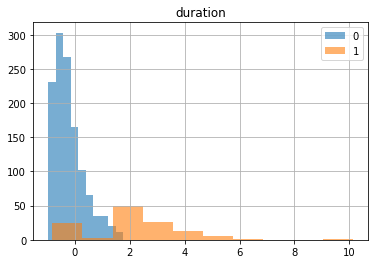

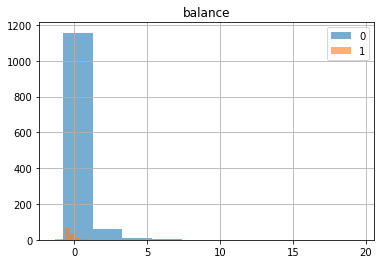

In [27]:
for i in ['duration','balance']:
    plt.figure(i)
    results.groupby(0)[i].hist(alpha = .6)
    plt.title(i)
    plt.legend('01')
# For the continuous fields, a longer duration was associated with a predicted positive response.

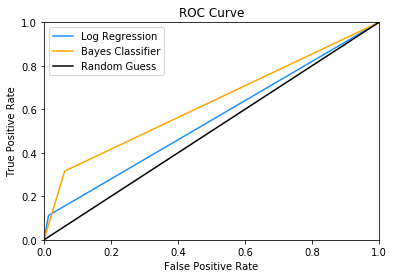

In [28]:
#Logistic Regression plot components
fpr, tpr, threshold  = metrics.roc_curve(test_y, model1_pred)
roc_auc_1 = metrics.auc(fpr, tpr)
#Bayes Classifier plot components
fpr_2, tpr_2, threshold  = metrics.roc_curve(test_y, model2_pred)
roc_auc_2 = metrics.auc(fpr, tpr)

#Compare ROC curve for both models
plt.title('ROC Curve')
plt.plot(fpr,tpr,'dodgerblue', label = 'Log Regression')
plt.plot(fpr_2,tpr_2,'orange',label = 'Bayes Classifier')
plt.plot([0, 1], [0, 1],'black',label = 'Random Guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()
